In [1]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
import scanpy as sc
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/rnamat.csv")
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
mat.shape

compiled!


(626, 22241)

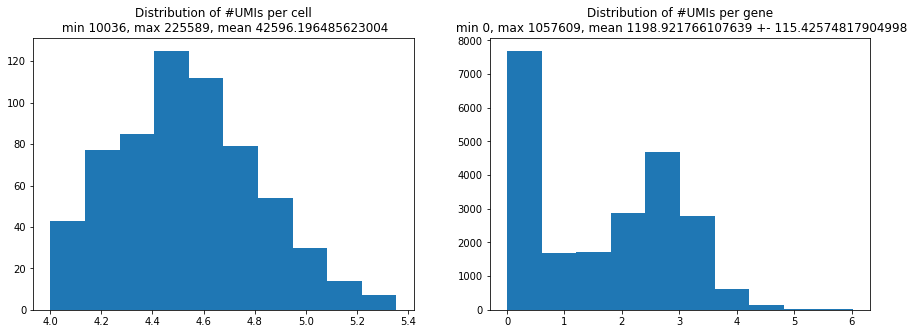

In [3]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.show()

Text(0.5, 1.0, 'Distribution of CV, mean 1.4662495368124753 sd 1.0003227369510244')

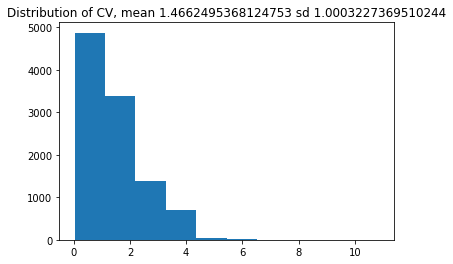

In [4]:
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

(626, 3951)


Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 100, max 2601, mean 257.64464692482915 +1 11.208466954917885')

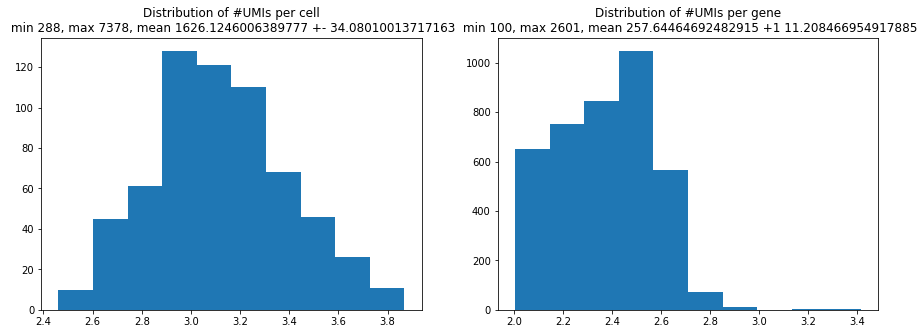

In [5]:
mat = mat[:, CV >= 1.5]
print(mat.shape)
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

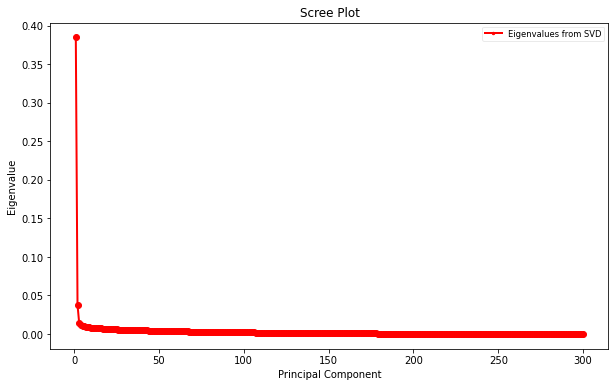

In [6]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
test = mat[:300, :300]
U, S, V = np.linalg.svd(test) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(test)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
fig.savefig('Zoomed in Scree Plot.png')
#leg.draggable(state=True)

626
{'[-2.8817508 -1.6975012]': 'C_L_BREAST_AAGACTCGTGGTACAG', '[-3.4870846 -1.3623449]': 'C_L_BREAST_ACTGATGGTCAGGTGA', '[-1.9017634  1.073217 ]': 'C_L_BREAST_ATGAGGGAGCTTAAGA', '[-7.6664143  2.6185718]': 'C_L_BREAST_CCGGACACAAGACAAT', '[-5.9671125  1.62763  ]': 'C_L_BREAST_CTGCCATCACAATGCT', '[-0.8606458   0.39488536]': 'C_L_BREAST_TAAGTCGCACCTCGTT', '[-1.201308   0.8087828]': 'C_L_BREAST_TCCATCGGTGCTCGTG', '[-3.6847057  1.6557271]': 'P_SKIN_AAAGAACGTAACAGTA', '[-0.809723  1.166746]': 'P_SKIN_AAATGGAGTATGTCCA', '[-1.5940309  1.8890884]': 'P_SKIN_AACAAAGGTGTGTTTG', '[-3.9956656  1.7151378]': 'P_SKIN_AACAACCTCTGGGCCA', '[-0.8526383  0.2931091]': 'P_SKIN_AACAGGGCAAGAGGCT', '[-7.3332596  1.3568909]': 'P_SKIN_AACCTTTGTCGTCATA', '[-2.559561    0.09009957]': 'P_SKIN_AACTTCTCATGTCAGT', '[-8.070287   1.9539905]': 'P_SKIN_AAGACAAAGTTTCTTC', '[-1.7678993  1.6571482]': 'P_SKIN_AAGACTCCAATACCCA', '[-1.268889   2.1043825]': 'P_SKIN_AAGTACCAGGAAAGGT', '[-4.3701496   0.18913202]': 'P_SKIN_AATGAAGAGC

Text(0.5, 1.0, 'Naive Clustering')

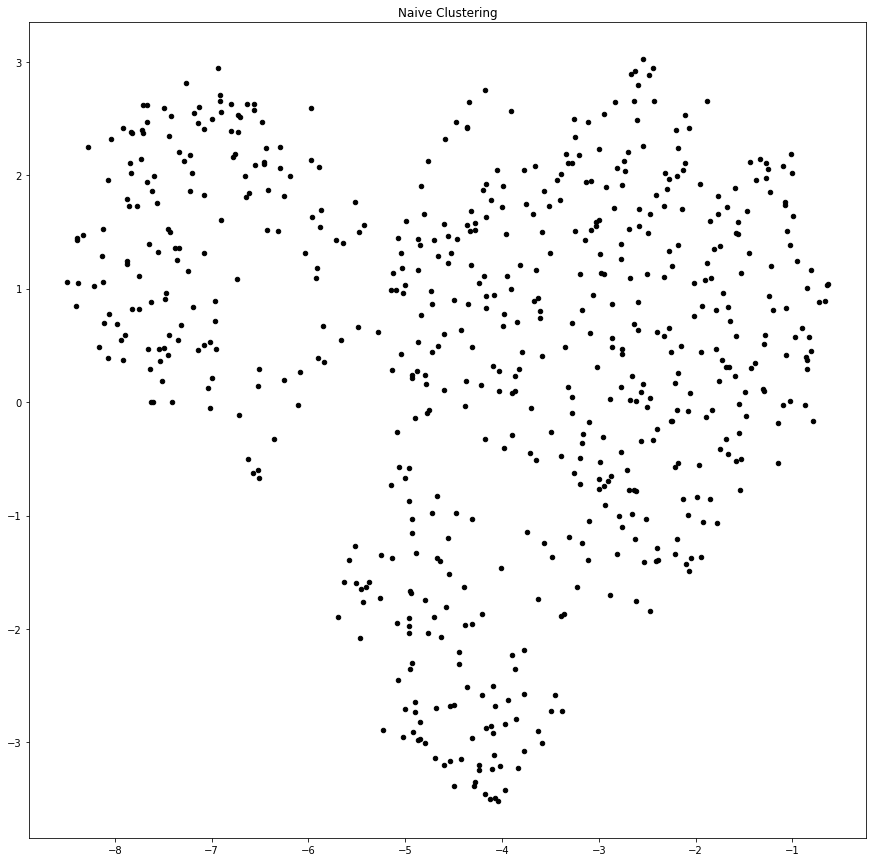

In [7]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='euclidean').fit_transform(mat_reduce)
print(len(embedding))
for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
print(true_indices)
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(15, 15))
plt.scatter(embedding[:,0],embedding[:,1], s=20.0, color='black')
plt.title('Naive Clustering')

[4 3 0 2 2 0 0 1 0 0 1 0 2 4 2 0 0 1 2 0 0 1 2 1 0 1 1 2 2 2 1 2 0 1 2 1 0
 2 0 0 0 2 4 1 1 4 0 1 4 2 0 1 1 2 1 1 1 1 1 1 2 2 1 0 2 4 1 2 1 2 2 1 0 1
 0 0 0 1 2 0 0 2 2 1 0 1 1 1 2 4 2 4 2 0 0 1 2 0 2 0 1 4 0 1 0 2 2 0 0 0 4
 1 4 4 0 2 0 0 2 4 1 2 1 1 1 0 2 1 2 2 1 2 1 3 1 0 0 4 0 4 0 2 0 0 0 1 4 1
 2 1 0 1 0 4 0 0 2 0 4 4 0 0 0 4 1 0 2 0 0 4 2 2 1 1 0 0 2 2 1 2 4 0 4 4 4
 1 0 1 4 0 0 0 2 1 2 2 1 4 2 1 1 0 4 2 4 2 4 1 2 0 2 0 0 2 2 0 4 0 2 0 0 1
 2 2 0 1 2 1 2 2 0 1 4 2 2 0 0 0 2 0 1 2 2 2 4 1 2 2 0 4 0 2 0 0 1 0 1 1 2
 1 2 0 4 3 0 4 2 0 4 4 2 0 4 1 2 2 0 0 3 0 2 1 0 4 2 4 0 2 0 0 0 0 0 0 1 0
 4 4 1 3 2 2 0 3 3 2 4 2 1 0 4 2 0 0 0 0 2 2 4 0 2 2 1 4 4 2 0 4 3 0 1 3 1
 0 4 2 0 2 2 3 0 1 1 3 4 0 2 0 4 0 1 2 3 3 4 0 3 3 3 2 3 1 0 0 4 3 0 2 1 0
 4 4 4 0 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 2 3 2 3 3 3 4 1 3 2 2 1 3 3 2 3 3
 4 2 4 3 2 4 3 3 3 4 3 3 3 3 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3
 3 3 1 3 3 3 1 3 2 2 1 4 2 2 4 4 4 2 2 2 1 3 1 1 2 1 3 3 3 2 1 2 1 3 0 1 3
 1 1 4 4 2 3 1 3 4 2 4 1 

[0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 2 0 0 1 0 0 0 1 0 0 0 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 2 1 1 0 2 2 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 2 0 0 2 0
 0 0 1 0 1 1 2 0 0 0 2 0 0 1 0 0 0 0 1 0 2 0 0 2 2 2 1 2 0 0 0 0 2 0 1 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 1 2 2 2 0 0 2 1 0 0 2 0 1 2 2
 0 1 0 0 1 0 2 2 2 0 2 0 2 0 1 1 2 0 2 2 0 2 1 2 2 2 0 2 2 2 0 2 2 2 2 2 2
 2 2 0 2 2 2 0 2 1 1 0 0 0 1 0 0 0 1 1 1 0 2 0 0 1 0 0 2 2 1 0 1 0 2 0 0 0
 0 0 0 0 0 2 0 0 0 1 0 0 

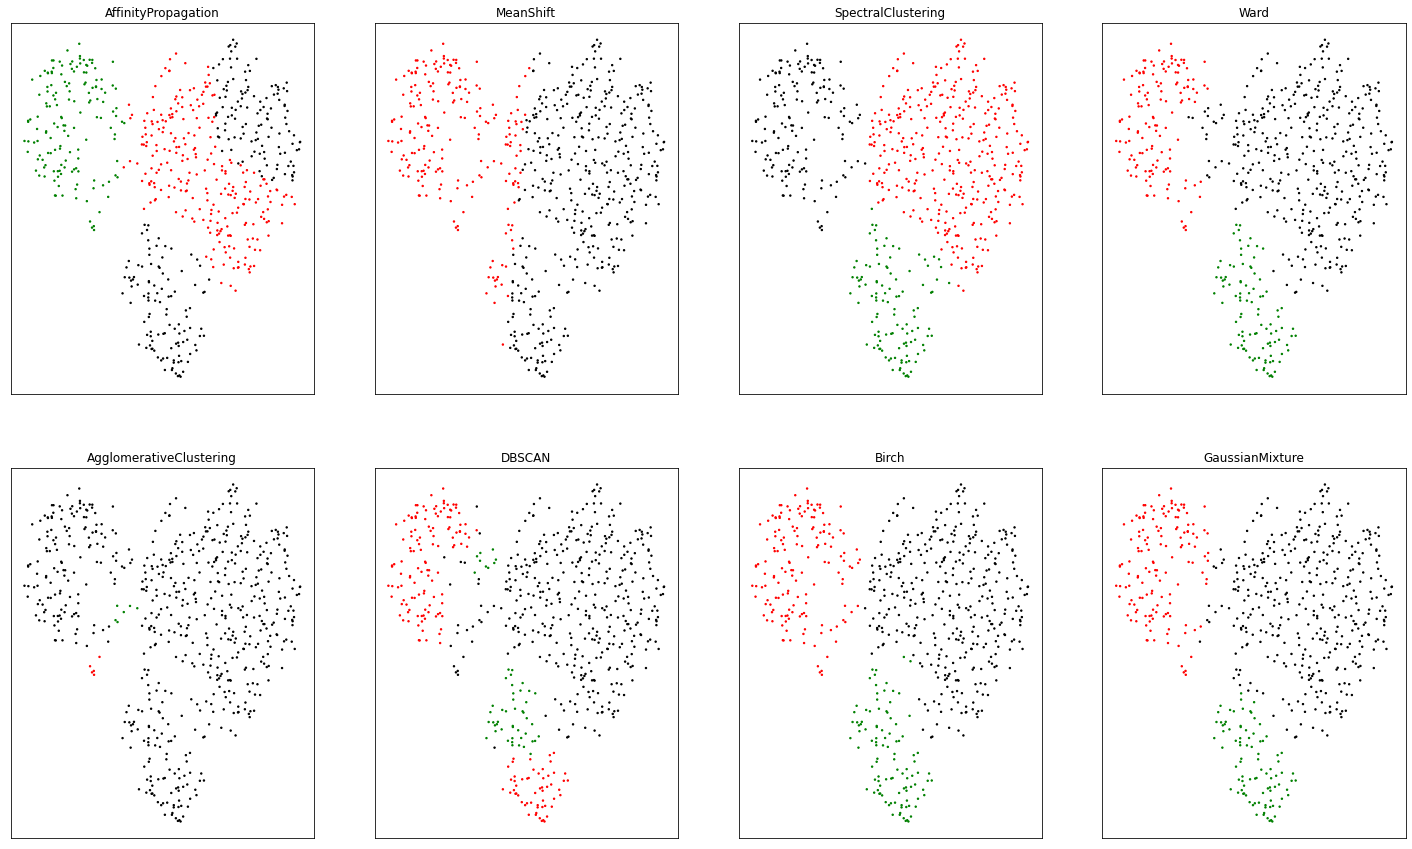

In [8]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':10, 'n_clusters':3}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(25,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['black', 'red', 'green']),
                                    int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)
    #Store the labels
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    print(labels)
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
   # print('{}'.format(name))
   # print(counts)
    print(embedding)
plt.savefig('All Clusters.png')

In [10]:
'''birch.fit(embedding)
birch_coords = {}
y_pred = birch.labels_.astype(np.int)
colors = np.append(colors, ["#000000"])
for i in range(len(embedding)):
    birch_coords.update({str(embedding[i]):y_pred[i]})
    if y_pred[i] == 0:
        color = 'red'
    elif y_pred[i] == 1:
        color = 'green'
    else: 
        color = 'blue'
    plt.scatter(embedding[i-1:i, 0], embedding[i-1:i, 1], s=4, color=color)
print(birch_coords)
true_labels = {}
for i in birch_coords:
    true_labels.update({true_indices[i]:birch_coords[i]})
print(true_labels)'''

def FindTrueLabels(algorithm):
    algorithm_coords = {}
    y_pred = algorithm.labels_.astype(np.int)
    for i in range(len(embedding)):
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

print(FindTrueLabels(birch))

{'C_L_BREAST_AAGACTCGTGGTACAG': 0, 'C_L_BREAST_ACTGATGGTCAGGTGA': 0, 'C_L_BREAST_ATGAGGGAGCTTAAGA': 0, 'C_L_BREAST_CCGGACACAAGACAAT': 1, 'C_L_BREAST_CTGCCATCACAATGCT': 1, 'C_L_BREAST_TAAGTCGCACCTCGTT': 0, 'C_L_BREAST_TCCATCGGTGCTCGTG': 0, 'P_SKIN_AAAGAACGTAACAGTA': 0, 'P_SKIN_AAATGGAGTATGTCCA': 0, 'P_SKIN_AACAAAGGTGTGTTTG': 0, 'P_SKIN_AACAACCTCTGGGCCA': 0, 'P_SKIN_AACAGGGCAAGAGGCT': 0, 'P_SKIN_AACCTTTGTCGTCATA': 1, 'P_SKIN_AACTTCTCATGTCAGT': 0, 'P_SKIN_AAGACAAAGTTTCTTC': 1, 'P_SKIN_AAGACTCCAATACCCA': 0, 'P_SKIN_AAGTACCAGGAAAGGT': 0, 'P_SKIN_AATGAAGAGCGTATGG': 0, 'P_SKIN_AATGAAGCACAAATAG': 1, 'P_SKIN_AATGAAGGTAGGACCA': 0, 'P_SKIN_AATGCCAGTTCTAACG': 0, 'P_SKIN_ACAAAGAGTTACAGCT': 0, 'P_SKIN_ACATCCCCAATTTCGG': 1, 'P_SKIN_ACCCTTGGTCTGCGCA': 0, 'P_SKIN_ACCTACCAGCAACAAT': 0, 'P_SKIN_ACCTACCCAATAAGGT': 0, 'P_SKIN_ACGATGTGTCATCGGC': 0, 'P_SKIN_ACGGTCGGTGCTCGTG': 1, 'P_SKIN_ACGTAGTAGCCGTAAG': 1, 'P_SKIN_ACTACGAAGGAACATT': 1, 'P_SKIN_ACTATTCAGATCGACG': 0, 'P_SKIN_ACTGATGGTTGAAGTA': 1, 'P_SKIN_ACT

In [13]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [14]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = FindTrueLabels(algorithm)
    
#     num1 = []
#     num2 = []
#     num3 = []
    
    num1 = ClusterIndicesNumpy(0, algorithm.labels_)
    num2 = ClusterIndicesNumpy(1, algorithm.labels_)
    num3 = ClusterIndicesNumpy(2, algorithm.labels_)
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    DataCollection.truthnum1 = {}
#     for i in labels:
#         if labels[i] == 0:
#             barcodes1.append(i)
#         elif labels[i] == 1:
#             barcodes2.append(i)
#         else:
#             barcodes3.append(i)
    for i in num1:
        barcodes1.update({cells[i]:i})
    for i in num2:
        barcodes2.update({cells[i]:i})
    for i in num3:
        barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                DataCollection.truthnum1.update({int(barcodes1[i[0:len(i)-1]]):'red'})
                #DataCollection.truthnum1.update((barcodes1[i]):'red'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for i in cluster1_line:
        for j in g2m_line:
            if i == j:
                g2mcount = g2mcount + 1
                DataCollection.truthnum1.update({int(barcodes1[i[0:len(i)-1]]):'red'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                DataCollection.truthnum1.update({int(barcodes1[i[0:len(i)-1]]):'black'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                DataCollection.truthnum1.update({int(barcodes2[i[0:len(i)-1]]):'black'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                DataCollection.truthnum1.update({int(barcodes2[i[0:len(i)-1]]):'red'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                DataCollection.truthnum1.update({int(barcodes2[i[0:len(i)-1]]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                DataCollection.truthnum1.update({int(barcodes3[i[0:len(i)-1]]):'red'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                DataCollection.truthnum1.update({int(barcodes3[i[0:len(i)-1]]):'black'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                DataCollection.truthnum1.update({int(barcodes3[i[0:len(i)-1]]):'red'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(DataCollection.truthnum1))
    res.write("")
DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
DataCollection(birch, 'birch_cluster1.txt', 'birch_cluster2.txt', 'birch_cluster3.txt', 'birch_results.txt')
DataCollection(affinity_propagation,'ap_cluster1.txt', 'ap_cluster2.txt', 'ap_cluster3.txt', 'ap_results.txt')
DataCollection(ward, 'waard_cluster1.txt', 'waard_cluster2.txt', 'waard_cluster3.txt', 'waard_results.txt')

[  0   1   2   5   6   7   8   9  10  11  13  15  16  17  19  20  21  23
  24  25  26  30  32  33  35  36  38  39  40  42  44  45  46  47  48  50
  51  52  54  55  56  57  58  59  62  63  65  66  68  71  72  73  74  75
  76  77  79  83  84  85  86  87  89  91  93  94  95  97  99 100 101 102
 103 104 107 108 109 110 112 113 114 116 117 119 120 122 123 124 125 127
 130 132 135 136 137 138 139 140 142 143 144 145 146 147 149 150 151 152
 153 154 155 157 158 159 160 161 162 163 164 165 167 168 169 172 173 174
 175 176 178 180 181 182 183 184 185 186 187 188 189 190 191 193 196 197
 199 200 201 202 204 206 207 209 211 212 215 217 219 220 221 224 225 227
 230 231 232 235 236 237 239 240 244 245 248 249 250 252 253 254 255 256
 257 259 261 262 264 265 267 268 269 271 272 273 276 277 279 281 282 283
 285 286 288 289 290 291 292 293 294 295 296 297 302 306 309 310 312 313
 314 315 318 319 322 323 324 326 327 329 330 332 333 334 336 340 341 342
 344 345 347 348 349 352 354 355 361 362 363 364 36

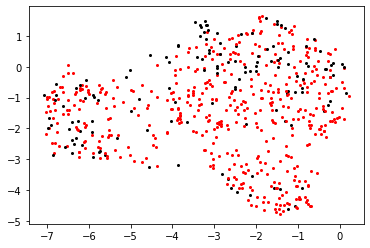

In [11]:
colors = []
DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
for i in DataCollection.truthnum1:
    colors.append(DataCollection.truthnum1[i])
for i in range(len(DataCollection.truthnum1)):
    plt.scatter(embedding[i-1:i, 0], embedding[i-1:i, 1], s=4, color=colors[i])
labels = ward.labels_
plt.savefig('Spectral Truth Plot.png')